# ETF Return & Risk Simulation for 2025 Using Real-World Outlook

This  simulates one-year future price paths for a list of popular ETFs (SPY, XLU, IGV, SMH, ARKK, XLE, QQQ, XLK) based on our best‐guess parameters informed by current economic, political, and industry trends. For selected ETFs (SMH and ARKK) we incorporate a jump-diffusion component to capture fat right-tail behavior.

We then compute risk metrics such as mean final price, median, skewness, kurtosis, Value at Risk (VaR), and the probability of doubling the price. Multiple plots illustrate the simulated price paths and the final price distributions.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as stats
from tqdm.notebook import tqdm

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Download Historical Data (Context Only)

(We use historical data to show price trends, though our simulation parameters here are “tuned” based on current economic/political outlook rather than solely on historical estimates.)

[*********************100%***********************]  8 of 8 completed


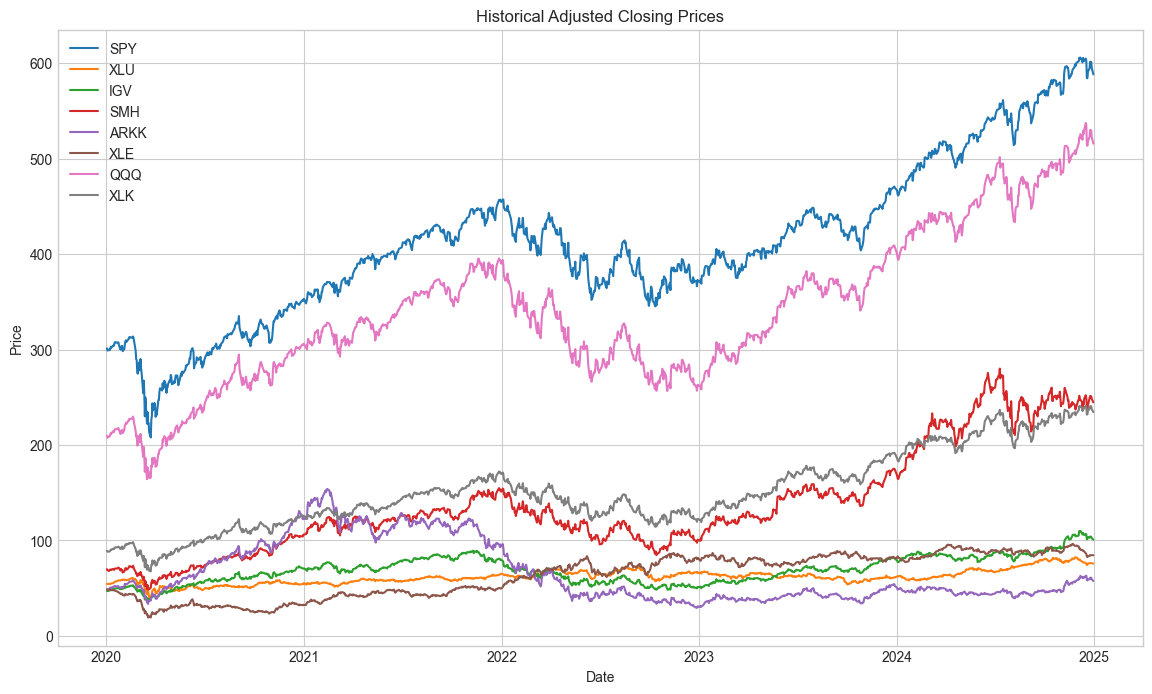

In [5]:
# Define ETFs and download historical adjusted close data
etfs = ["SPY", "XLU", "IGV", "SMH", "ARKK", "XLE", "QQQ", "XLK"]
start_date = "2020-01-01"
end_date = "2024-12-31"
data = yf.download(etfs, start=start_date, end=end_date, auto_adjust=False)["Adj Close"]

# Plot historical prices for context
plt.figure(figsize=(14,8))
for etf in etfs:
    plt.plot(data.index, data[etf], label=etf)
plt.title("Historical Adjusted Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

## 2. Define Simulation Parameters

We set annualized drift (mu) and volatility (sigma) for each ETF, plus jump parameters for SMH and ARKK (only).

In [6]:
# Number of trading days in a year and simulation settings
T = 1.0      # 1 year
N = 252      # trading days
dt = T / N
num_simulations = 5000  # number of simulated paths

# ETF simulation parameters based on our educated guesses:
# Prices are taken from the last available price in the historical data.
initial_prices = {etf: data[etf].iloc[-1] for etf in etfs}

# Define a dictionary with our parameter settings
# mu: annual drift, sigma: annual volatility.
# For jump parameters (if applicable): lambda: jumps per year, jump_mean: average jump return, jump_sigma: volatility of jump.
etf_params = {
    "SPY": {"mu": 0.10, "sigma": 0.15, "jumps": False},
    "XLU": {"mu": 0.06, "sigma": 0.10, "jumps": False},
    "IGV": {"mu": 0.15, "sigma": 0.25, "jumps": False},  # Could add jumps if desired.
    "SMH": {"mu": 0.20, "sigma": 0.30, "jumps": True, "lambda": 2, "jump_mean": 0.10, "jump_sigma": 0.08},
    "ARKK": {"mu": 0.25, "sigma": 0.35, "jumps": True, "lambda": 3, "jump_mean": 0.15, "jump_sigma": 0.10},
    "XLE": {"mu": 0.08, "sigma": 0.20, "jumps": False},
    "QQQ": {"mu": 0.17, "sigma": 0.28, "jumps": False},
    "XLK": {"mu": 0.16, "sigma": 0.26, "jumps": False},
}

## 3. Define Simulation Functions

We create two functions:
- `simulate_gbm` for standard geometric Brownian motion.
- `simulate_jump_diffusion` for ETFs where we add a jump component.

The jump-diffusion model uses the idea that in each time step a Poisson process (with probability lambda*dt) triggers a jump whose factor is lognormally distributed.

In [7]:
def simulate_gbm(S0, mu, sigma, T, N, num_simulations):
    """Simulate geometric Brownian motion paths."""
    dt = T / N
    # Pre-allocate the array
    paths = np.zeros((N+1, num_simulations))
    paths[0] = S0
    # Generate random shocks
    for t in range(1, N+1):
        Z = np.random.normal(0, 1, num_simulations)
        paths[t] = paths[t-1] * np.exp((mu - 0.5 * sigma**2)*dt + sigma * np.sqrt(dt)*Z)
    return paths

def simulate_jump_diffusion(S0, mu, sigma, T, N, num_simulations, jump_lambda, jump_mean, jump_sigma):
    """
    Simulate jump-diffusion paths.
    jump_lambda: expected number of jumps per year
    jump_mean: average jump return (e.g., 0.15 for a 15% jump)
    jump_sigma: volatility of jump return
    """
    dt = T / N
    paths = np.zeros((N+1, num_simulations))
    paths[0] = S0
    # Pre-calculate jump probabilities for each day
    # Poisson process: probability of a jump in dt is: p_jump = jump_lambda * dt
    p_jump = jump_lambda * dt
    for t in range(1, N+1):
        Z = np.random.normal(0, 1, num_simulations)
        # Standard GBM component
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt) * Z
        # Determine which simulations have a jump
        jump_occurrence = np.random.rand(num_simulations) < p_jump  # Boolean array
        # For simulations with a jump, draw a jump factor from a lognormal distribution
        # so that jump multiplier Y = exp(jump_return) where jump_return ~ N(jump_mean, jump_sigma^2)
        jump_multiplier = np.ones(num_simulations)
        if np.any(jump_occurrence):
            jump_returns = np.random.normal(jump_mean, jump_sigma, jump_occurrence.sum())
            jump_multiplier[jump_occurrence] = np.exp(jump_returns)
        # Update price paths with jump factor
        paths[t] = paths[t-1] * np.exp(drift + diffusion) * jump_multiplier
    return paths

## 4. Run Simulations for Each ETF

We simulate 1‑year price paths for each ETF. For those with jumps enabled (SMH and ARKK) we use the jump-diffusion function; otherwise, we use standard GBM.

In [8]:
simulated_paths = {}  # dictionary to hold simulation arrays
final_prices = {}     # dictionary to hold final simulated prices

for etf in etfs:
    params = etf_params[etf]
    S0 = initial_prices[etf]
    print(f"Simulating {etf} with initial price {S0:.2f}")
    if params.get("jumps", False):
        paths = simulate_jump_diffusion(S0, params["mu"], params["sigma"], T, N, num_simulations,
                                        jump_lambda=params["lambda"],
                                        jump_mean=params["jump_mean"],
                                        jump_sigma=params["jump_sigma"])
    else:
        paths = simulate_gbm(S0, params["mu"], params["sigma"], T, N, num_simulations)
    simulated_paths[etf] = paths
    final_prices[etf] = paths[-1]

Simulating SPY with initial price 588.22
Simulating XLU with initial price 75.76
Simulating IGV with initial price 100.94
Simulating SMH with initial price 244.66
Simulating ARKK with initial price 57.61
Simulating XLE with initial price 84.55
Simulating QQQ with initial price 515.61
Simulating XLK with initial price 234.47


## 5. Analyze Simulation Results

For each ETF, we compute:
- Mean and median of final prices  
- Skewness and kurtosis  
- 5% Value at Risk (VaR)  
- Probability of final price being at least double the initial price (as an indicator of a “fat right tail”)

We then print out a summary table.

In [9]:
results = []
for etf in etfs:
    fp = final_prices[etf]
    mean_price = np.mean(fp)
    median_price = np.median(fp)
    skewness = stats.skew(fp)
    kurtosis = stats.kurtosis(fp)
    var_5 = np.percentile(fp, 5)
    prob_double = np.mean(fp >= 2 * initial_prices[etf])
    
    results.append({
        "ETF": etf,
        "Initial Price": initial_prices[etf],
        "Mean Final Price": mean_price,
        "Median Final Price": median_price,
        "Skewness": skewness,
        "Kurtosis": kurtosis,
        "VaR 5%": var_5,
        "Prob (>=2x)": prob_double
    })

results_df = pd.DataFrame(results)
print("Simulation Results (1-year forecasts):")
print(results_df)

Simulation Results (1-year forecasts):
    ETF  Initial Price  Mean Final Price  Median Final Price  Skewness  \
0   SPY     588.219971        651.524585          643.585868  0.484549   
1   XLU      75.760002         80.301592           79.848016  0.309114   
2   IGV     100.940002        117.363622          113.831139  0.724027   
3   SMH     244.660004        369.799870          342.594900  1.434499   
4  ARKK      57.610001        121.789727          106.330068  2.361462   
5   XLE      84.550003         91.336417           89.486270  0.596603   
6   QQQ     515.609985        611.367261          589.617982  0.875409   
7   XLK     234.470001        275.238325          265.736267  0.822457   

    Kurtosis      VaR 5%  Prob (>=2x)  
0   0.362186  502.931311       0.0000  
1   0.136011   67.863761       0.0000  
2   0.766948   75.765882       0.0102  
3   3.748792  201.010252       0.1606  
4  10.369046   53.159488       0.4324  
5   0.687472   64.286658       0.0008  
6   1.529557  

## 6. Plot Simulation Paths & Distributions

We show:
- A few sample simulation paths for each ETF  
- The histogram of the final prices for each ETF (which lets us visually compare tail behavior)

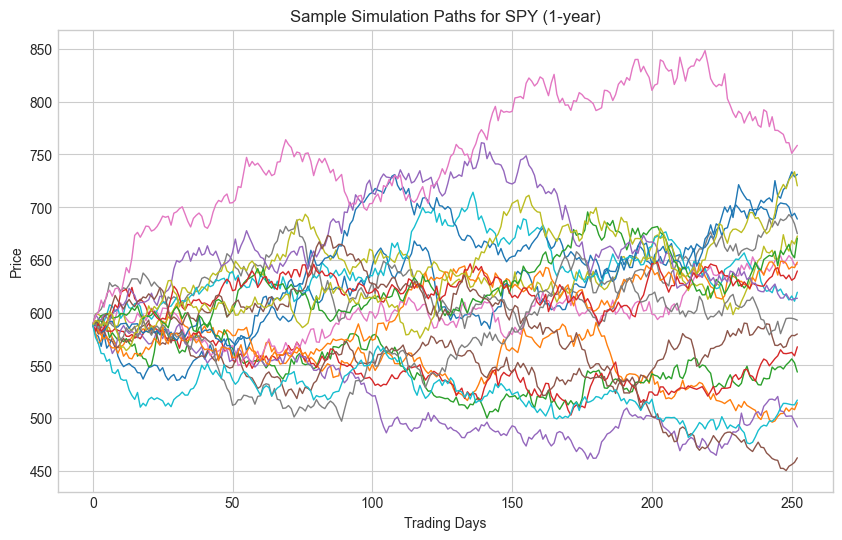

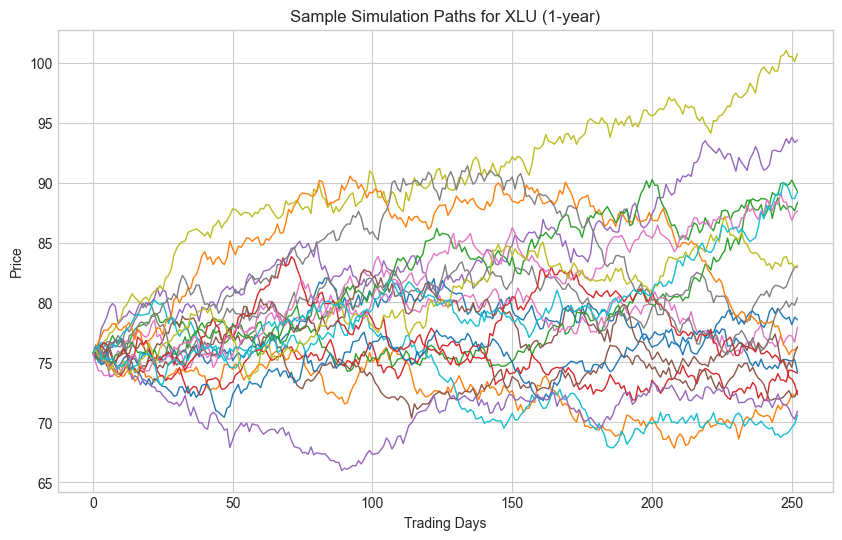

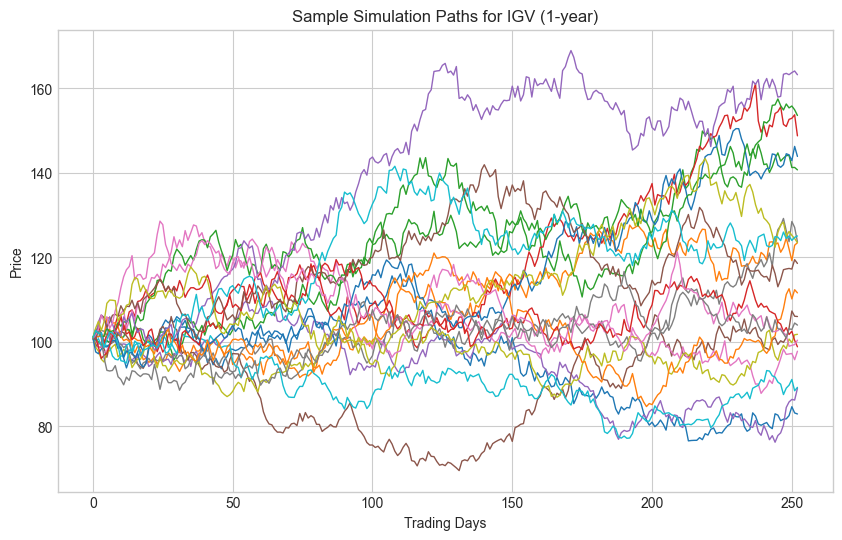

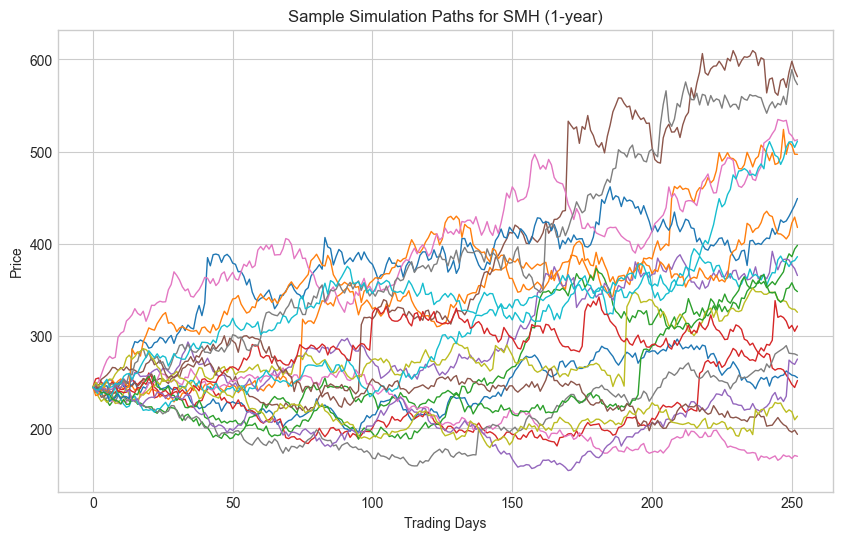

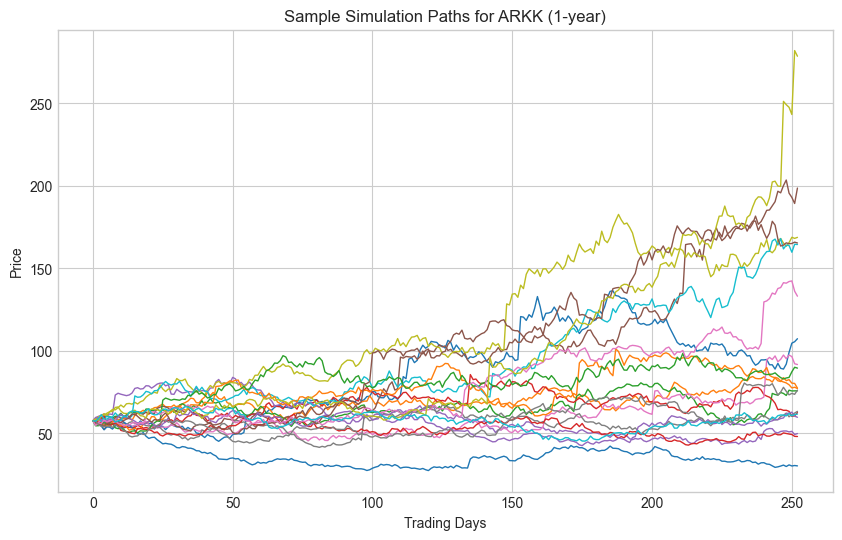

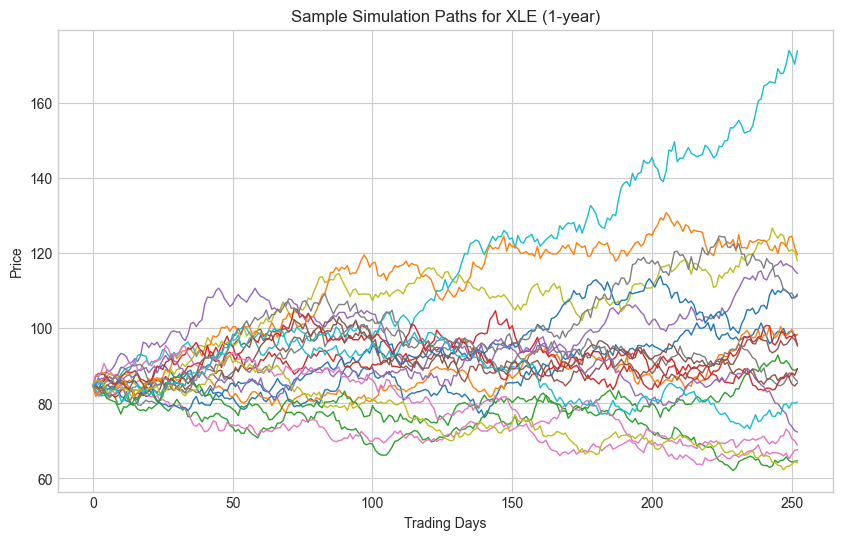

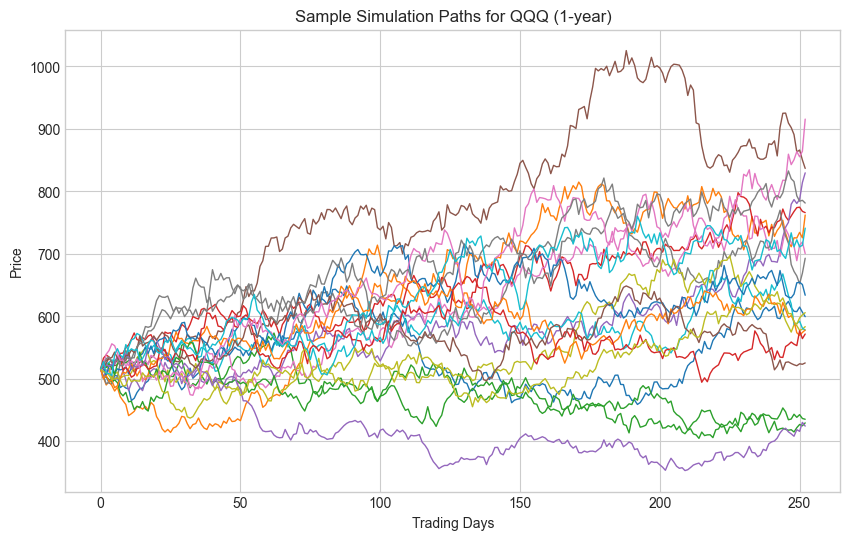

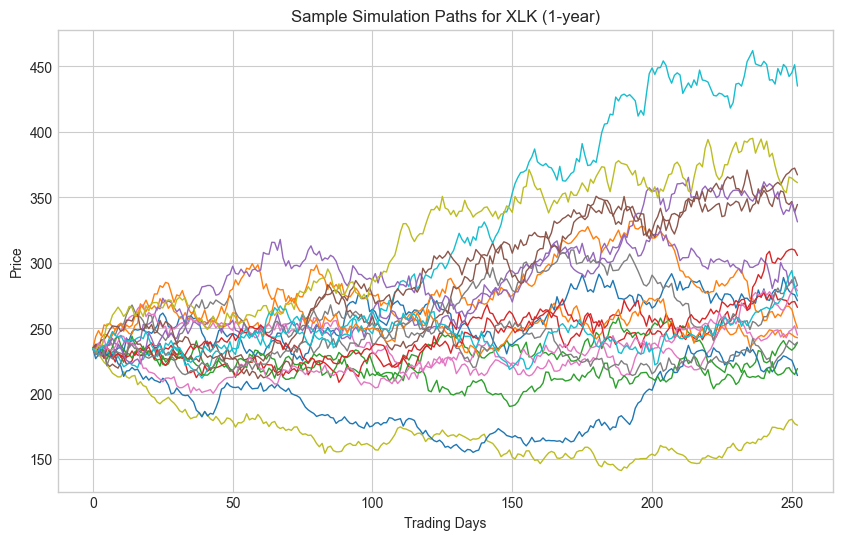

In [10]:
# Plot sample simulation paths (first 20 paths for each ETF)
num_sample_paths = 20
for etf in etfs:
    plt.figure(figsize=(10,6))
    plt.plot(simulated_paths[etf][:, :num_sample_paths], lw=1)
    plt.title(f"Sample Simulation Paths for {etf} (1-year)")
    plt.xlabel("Trading Days")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

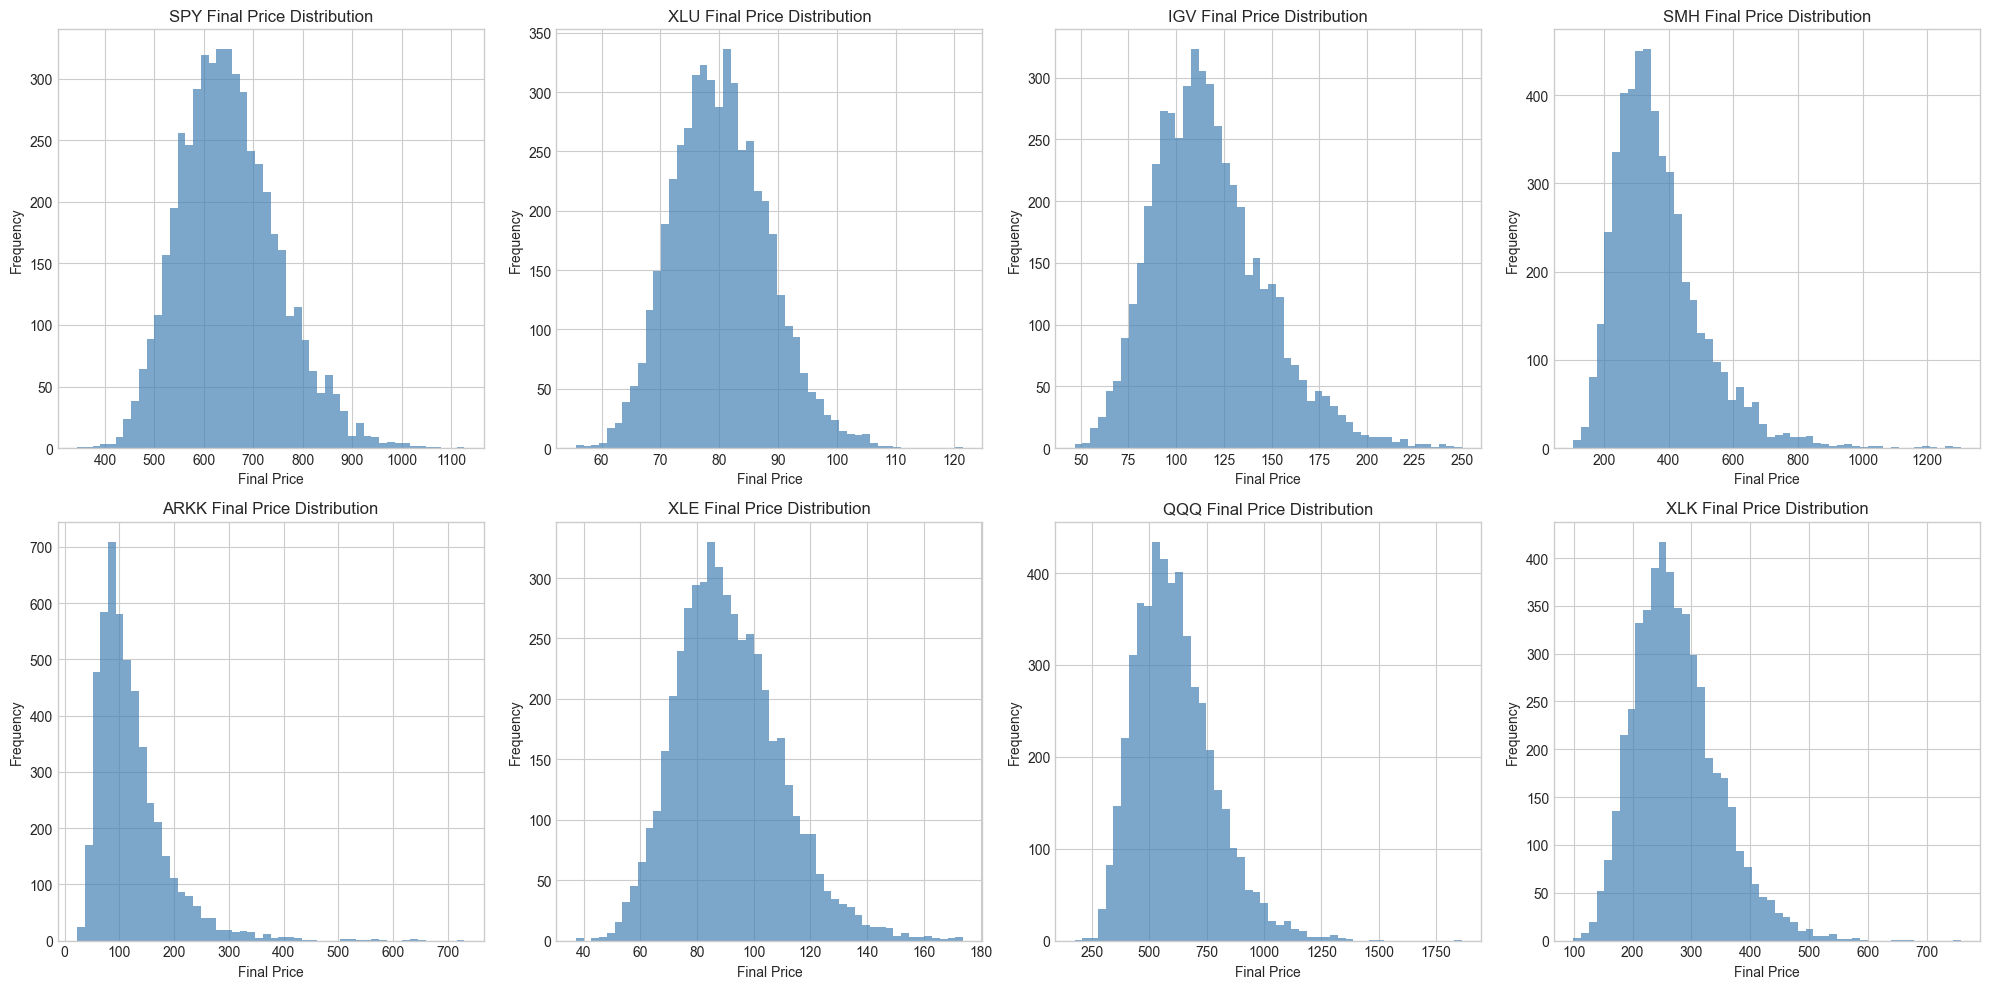

In [11]:
# Plot histogram of final prices for each ETF
fig, axes = plt.subplots(2, 4, figsize=(20,10))
axes = axes.flatten()
for i, etf in enumerate(etfs):
    axes[i].hist(final_prices[etf], bins=50, alpha=0.7, color='steelblue')
    axes[i].set_title(f"{etf} Final Price Distribution")
    axes[i].set_xlabel("Final Price")
    axes[i].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

## End of Notebook